# Analysis of clinical variatns of ORC1 protein

In [92]:
from clinvar_functions import *
import pandas as pd
import matplotlib.pyplot as plt

# Set option to display all rows
pd.set_option('display.max_rows', None)

## ORC1 regions

In [2]:
# List of intervals for particular feature

#LLPS = [(360, 382), (412, 476), (577, 636), (677, 729), (757, 816)] # Chinees paper
#IDR_total = [(183, 476)] # Chinees paper
#G4_RNA = [(413, 511)] # Hoshina paper
#CDCD6=[(180, 240)] # CDC6 paper
#BP=[(354, 368), (378, 392)] # CDC6 paper
IDR = [(183, 511)]
RBD = [(413, 511)]

# Positions
IDR_pos = generate_list(IDR)
RBD_pos = generate_list(RBD)
# G4_RNA_positions = generate_list(G4_RNA)
# LLPS_positions = generate_list(LLPS)
# CDCD6_positions = generate_list(CDCD6)
# BP_positions = generate_list(BP)

## Read data

In [3]:
# Set option to display all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

df = pd.read_csv('clinvar_result.csv', sep = "\t")
df = df[df['Gene(s)'] == 'ORC1'] # save only ORC1 gene - delete 7 records
df.shape

(333, 25)

In [4]:
df.columns

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession',
       'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome',
       'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID',
       'Canonical SPDI', 'Variant type', 'Molecular consequence',
       'Germline classification', 'Germline date last evaluated',
       'Germline review status', 'Somatic clinical impact',
       'Somatic clinical impact date last evaluated',
       'Somatic clinical impact review status', 'Oncogenicity classification',
       'Oncogenicity date last evaluated', 'Oncogenicity review status',
       'Unnamed: 24'],
      dtype='object')

In [11]:
# Keep only protein changes
df = df.dropna(subset=["Protein change"])

## Look at the different columns of df

In [ ]:
df["Condition(s)"].value_counts()

In [ ]:
df["Germline classification"].value_counts()

In [ ]:
df['Germline review status'].value_counts()

## Get list of transcript IDs

In [5]:
IDs = df['Name'].apply(lambda x: x.split(":")[0])
IDs.value_counts()

Name
NM_004153.4(ORC1)       332
NM_001190818.1(ORC1)      1
Name: count, dtype: int64

## Add new column: Condition_new

In [6]:
df['Condition_new'] = df['Condition(s)'].map(rename_condition, na_action='ignore')

In [7]:
df['Condition_new'].value_counts()

Condition_new
not provided                        211
Meier-Gorlin syndrome 1 probably     42
Meier-Gorlin syndrome 1              30
Inborn genetic diseases              30
Inborn genetic diseases probably     12
ORC1-related disorder probably        6
Name: count, dtype: int64

# Visualisation

## Analyse Germline review status

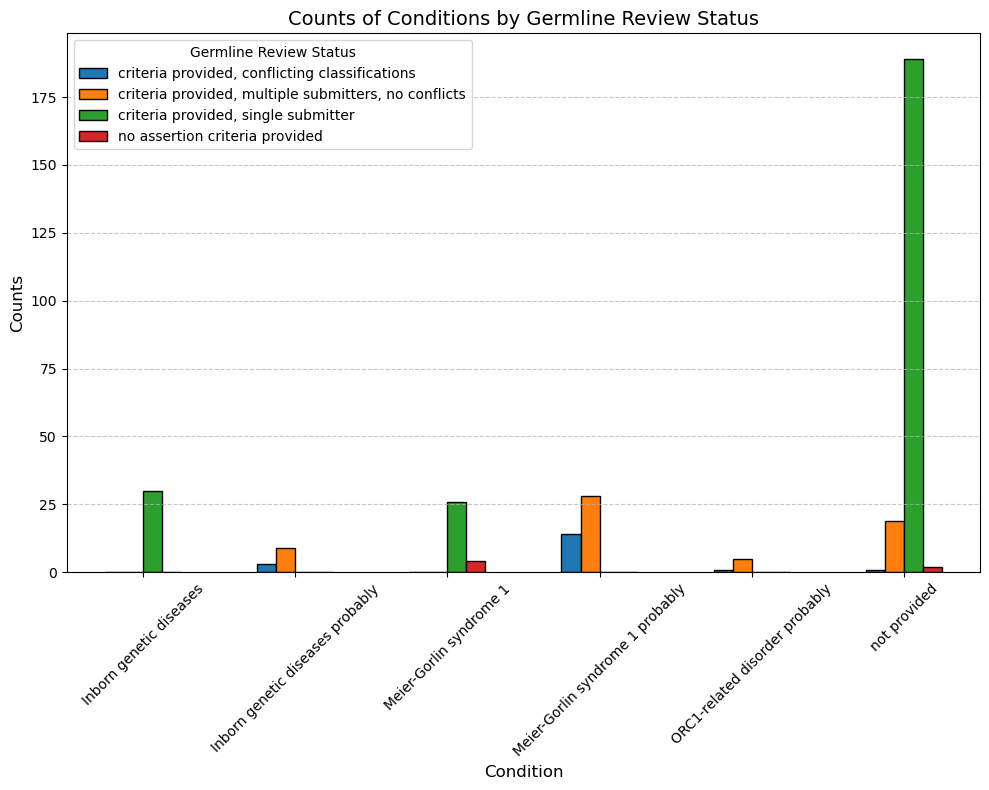

In [30]:
# Data
grouped_counts = df.groupby("Germline review status")["Condition_new"].value_counts()
plot_data = grouped_counts.reset_index(name="Counts")
plot_data

# Pivot the data for better visualization
pivot_data = plot_data.pivot(index="Condition_new", columns="Germline review status", values="Counts")

# Plot as a bar chart
pivot_data.plot(kind="bar", figsize=(10, 8), edgecolor="black")

plt.title("Counts of Conditions by Germline Review Status", fontsize=14)
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Germline Review Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

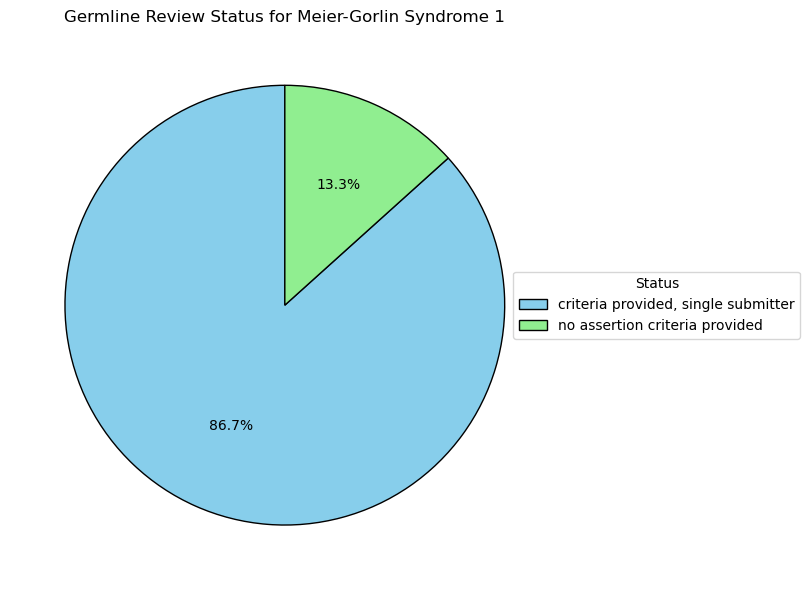

In [145]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
pie_chart = status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for Meier-Gorlin Syndrome 1"
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.45, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

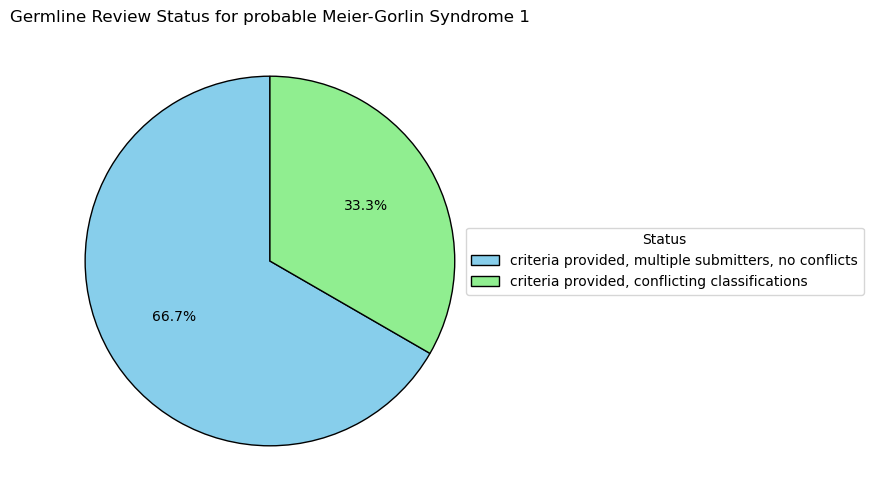

In [149]:
# Filter the data for the specific condition
filtered_data = df['Germline review status'][df["Condition_new"] =="Meier-Gorlin syndrome 1 probably"]
# Count the occurrences of each status
status_counts = filtered_data.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
status_counts.plot.pie(
    labels=None,
    autopct='%1.1f%%',  # Show percentages
    startangle=90,      # Rotate start angle
    colors=['skyblue', 'lightgreen', 'orange'],  # Optional: specify colors
    wedgeprops={'edgecolor': 'black'},  # Add edge color
    title="Germline Review Status for probable Meier-Gorlin Syndrome 1"
)

# Add a legend at the center right
plt.legend(
    labels=status_counts.index,  # Use the status names as labels
    title="Status",              # Add a title to the legend
    loc="center right",          # Position the legend at the center-right
    bbox_to_anchor=(1.80, 0.5),  # Offset for better alignment
)

plt.ylabel("")  # Remove default y-axis label
plt.show()

## Filtration: Meier-Gorlin syndrome 1 and probable Meier-Gorlin syndrome 1

In [101]:
MSG = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1") &
    (df["Germline review status"] == "criteria provided, single submitter")
]
MSG.shape

(26, 26)

In [102]:
MSG_probably = df[
    (df["Condition_new"] == "Meier-Gorlin syndrome 1 probably") &
    (df["Germline review status"] == "criteria provided, multiple submitters, no conflicts")
]
MSG_probably.shape

(28, 26)

Number of variats is 18
Number of variats is 21


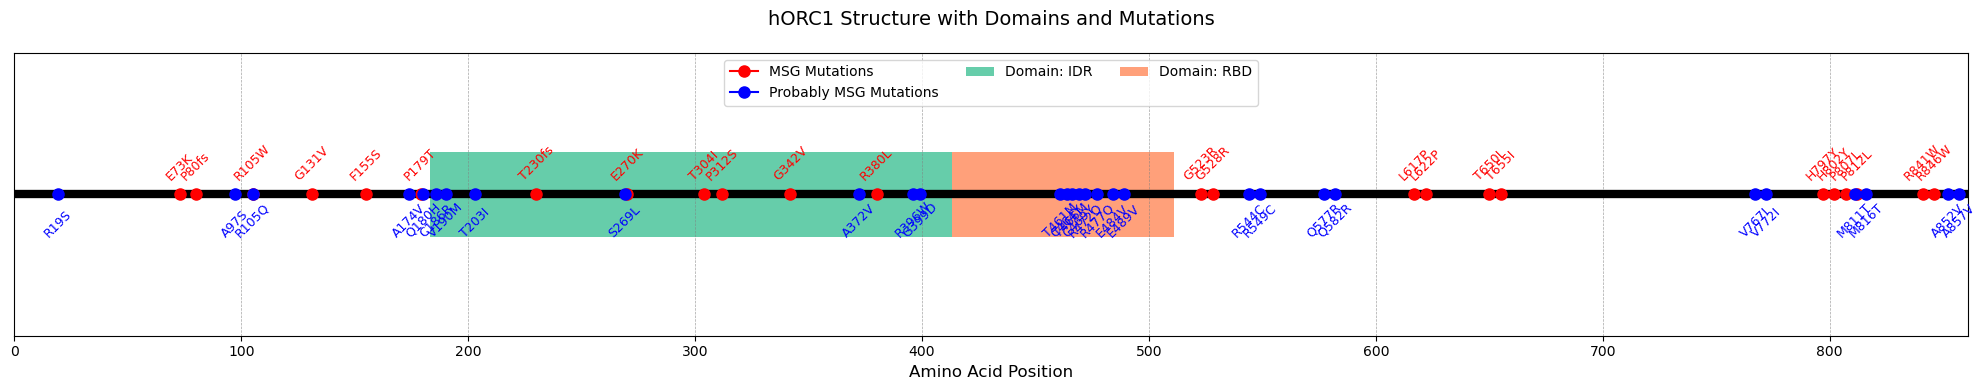

In [135]:
# Define protein information
protein_length = 861  # Example: protein is 800 amino acids long
domains = [
    {"name": "IDR", "start": 183, "end": 413, "color": "mediumaquamarine", "alpha": 0.6},
    {"name": "RBD", "start": 413, "end": 511, "color": "lightsalmon", "alpha": 0.8},
]
mutations_MSG = create_mutation_dict(MSG)
mutations_MSG_probably = create_mutation_dict(MSG_probably)

# Create the figure
fig, ax = plt.subplots(figsize=(20, 4))

# Draw the protein backbone
ax.plot([0, protein_length], [0.5, 0.5], color="black", lw=6)

# Draw the domains with labels
for domain in domains:
    ax.barh(0.5, domain["end"] - domain["start"], left=domain["start"], height=0.3,
            color=domain["color"], label=f"Domain: {domain['name']}")

# Mark the mutations for MSG (above the backbone)
for i, mutation in enumerate(mutations_MSG):
    ax.plot(mutation["position"], 0.5, marker="o", color="red", markersize=8,
            label="MSG Mutations" if i == 0 else "")
    ax.text(mutation["position"], 0.55, mutation["label"], ha="center", fontsize=9, rotation=45, color="red")

# Mark the mutations for MSG_probably (below the backbone)
for i, mutation in enumerate(mutations_MSG_probably):
    ax.plot(mutation["position"], 0.5, marker="o", color="blue", markersize=8,
            label="Probably MSG Mutations" if i == 0 else "")
    ax.text(mutation["position"], 0.35, mutation["label"], ha="center", fontsize=9, rotation=45, color="blue")

# Add gridlines for alignment
ax.grid(axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add labels and legend
ax.set_xlim(0, protein_length)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Amino Acid Position", fontsize=12)
ax.legend(loc="upper center", ncol=3, frameon=True, fontsize=10)

# Add a title
ax.set_title("hORC1 Structure with Domains and Mutations", fontsize=14, pad=20)

# Show the plot
plt.tight_layout()
plt.show()

## List of mutations in every domain

In [ ]:
criterion = 'criteria provided, conflicting classifications'
disease = 'Meier-Gorlin syndrome 1'
protein_mut = df['Protein change'][(df['Germline review status'] == criterion) & (df['Condition_new']==disease)]
yes, no = mutation_analysis(protein_mut, RBD_pos)  

## Amino acids analysis

Analyse the percantage of Arginine (R) in different domains of ORC1 protein

In [ ]:
# Protein sequences
IDR = "AAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRS"
G4 = "AAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEF"
CDC6 = "QESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELG"
ORC="MAHYPTRLKTRKTYSWVGRPLLDRKLHYQTYREMCVKTEGCSTEIHIQIGQFVLIEGDDDENPYVAKLLELFEDDSDPPPKKRARVQWFVRFCEVPACKRHLLGRKPGAQEIFWYDYPACDSNINAETIIGLVRVIPLAPKDVVPTNLKNEKTLFVKLSWNEKKFRPLSSELFAELNKPQESAAKCQKPVRAKSKSAESPSWTPAEHVAKRIESRHSASKSRQTPTHPLTPRARKRLELGNLGNPQMSQQTSCASLDSPGRIKRKVAFSEITSPSKRSQPDKLQTLSPALKAPEKTRETGLSYTEDDKKASPEHRIILRTRIAASKTIDIREERTLTPISGGQRSSVVPSVILKPENIKKRDAKEAKAQNEATSTPHRIRRKSSVLTMNRIRQQLRFLGNSKSDQEEKEILPAAEISDSSSDEEEASTPPLPRRAPRTVSRNLRSSLKSSLHTLTKVPKKSLKPRTPRCAAPQIRSRSLAAQEPASVLEEARLRLHVSAVPESLPCREQEFQDIYNFVESKLLDHTGGCMYISGVPGTGKTATVHEVIRCLQQAAQANDVPPFQYIEVNGMKLTEPHQVYVQILQKLTGQKATANHAAELLAKQFCTRGSPQETTVLLVDELDLLWTHKQDIMYNLFDWPTHKEARLVVLAIANTMDLPERIMMNRVSSRLGLTRMCFQPYTYSQLQQILRSRLKHLKAFEDDAIQLVARKVAALSGDARRCLDICRRATEICEFSQQKPDSPGLVTIAHSMEAVDEMFSSSYITAIKNSSVLEQSFLRAILAEFRRSGLEEATFQQIYSQHVALCRMEGLPYPTMSETMAVCSHLGSCRLLLVEPSRNDLLLRVRLNVSQDDVLYALKDE"

# Calculations
ORC1_R = percantage_aa(seq=ORC, A="R")
IDR_R = percantage_aa(seq=IDR, A="R")
G4_R = percantage_aa(seq=G4, A="R")
CDC6_R = percantage_aa(seq=CDC6, A="R")

ORC1_G = percantage_aa(seq=ORC, A="G")
IDR_G = percantage_aa(seq=IDR, A="G")
G4_G = percantage_aa(seq=G4, A="G")
CDC6_G = percantage_aa(seq=CDC6, A="G")

print(f"Arginines in different ORC1 domains:")
print(f"ORC1: {ORC1_R} ; IDR: {IDR_R} ; G4 binding: {G4_R} ; CDC6 binding: {CDC6_R}")

print(f"Glycines in different ORC1 domains:")
print(f"ORC1: {ORC1_G} ; IDR: {IDR_G} ; G4 binding: {G4_G} ; CDC6 binding: {CDC6_G}")